In [1]:
from datetime import datetime, timedelta
myrun_start = datetime.now()

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import periodogram
from tsfeatures import *              # NIXTLA

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve

# Постановка задачи

## Описание данных
Источником данных послужили пять групп по 100 файлов, каждый файл содержал 23.6 секундный ряд электроэнцефалограммы (ЭЭГ), который был разрезан на 23 равных сегмента.  В итоге получили $5 \cdot 100 \cdot 23 = 11500$ фрагментов ЭЭГ одинаковой длины. Частота сэмплирования ЭЭГ была равна $(23 \cdot 178 + 3) / 23.6 \,сек \approx 173.6 \,Гц$

В данных задания содержатся 11500 размеченных записей, каждая запись - это отдельный односекундный сегмент ЭЭГ, плюс разметка в последнем поле.

Поля с префиксом "X" - это отсчеты каждого временного ряда (178 шт.), а поле "y" содержит разметку на классы сегментов и принимает значения {1, 2, 3, 4, 5} со следующей семантикой:
1) ЭЭГ судорожной активности (приступ эпилепсии) - целевой класс;
2) ЭЭГ из области, где находилась опухоль;
3) ЭЭГ из здоровой области мозга, после определения, в какой области мозга находится опухоль;
4) во время записи ЭЭГ-сигнала пациент держал глаза закрытыми;
5) во время записи ЭЭГ-сигнала мозга пациент держал глаза открытыми.

**NB!:** "*All subjects falling in classes 2, 3, 4, and 5 are subjects who did not have epileptic seizure. Only subjects in class 1 have epileptic seizure*", причем объектами тут называются пациенты (точнее 500 файлов-источников). Это весьма важное для корректной интерпретации данных замечание из комментариев к датасету тут https://www.kaggle.com/datasets/harunshimanto/epileptic-seizure-recognition - оно означает, что бинарная разметка для целевого класса one-vs-rest точно соответствует классификации случаев эпилепсии, а не смеси эпилепсии и схожих состояний, вызванных опухолью мозга.

## Немного из предметной области
Опухоль мозга, даже доброкачественная, разрастаясь может надавить на критические участки мозга, ответственные за важные функции, и человек при этом может потерять подвижность, способность говорить и/или оказаться в состоянии, которое внешне не отличается от приступа эпилепсии, но различаются на ЭЭГ.

Исследование ЭЭГ занимает от 30 минут (стандарт) или пары часов (детальная), и до суток при необходимости точного диагноза - такая длительность вызвана необходимостью проведения измерений при различных индуцируемых врачом состояниях пациента. Поэтому ЭЭГ-файлы длительностью 23.6 сек, послужившие источником данных, также не могут быть полной ЭЭГ - скорее всего, это характерные фрагменты, ставшие причиной профессиональной разметки типов фрагментов. Возможно, разметку 23.6 секундных файлов автоматически делал сам медицинский прибор.

Более детально тут: https://childclinic.ru/parents/articles/eeg-monitoring/  

## Задача
Обучить бинарный классификатор, находящий среди сегментов ЭЭГ сегменты с приступом эпилепсии

# Чтение данных

In [3]:
raw_df = pd.read_csv('data/Epileptic Seizure Recognition.txt', index_col=0)  # название первой колонки типично для сохранения с индексом 
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Columns: 179 entries, X1 to y
dtypes: int64(179)
memory usage: 15.8+ MB


In [4]:
raw_df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
Unnamed,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
X15.V1.924,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5


In [5]:
raw_df.index.value_counts(dropna=False).head(3)

Unnamed
X16.V1.210    1
X21.V1.791    1
X15.V1.924    1
Name: count, dtype: int64

**все индексы уникальны - проверим, есть ли один пропуск** (если бы было больше одного - он бы попал в первую строку вывода выше)

In [6]:
print('FYI: количество пропусков в поле ID =', raw_df.index.isna().sum())

FYI: количество пропусков в поле ID = 0


**да, это подходящий индекс и ID сегмента одновременно**

# EDA

**на первый взгляд никакого глубокого исследования тут не возможно, так как есть только ID, значения случайной величины и разметка для гомоморфных временных рядов, однако при внимательном рассмотрении видно, что ID ряда содержит три поля с какой-то информацией**

## исследуем кодировку ID сегмента ЭЭГ

### всегда ли там три поля?

In [7]:
raw_df.index.map(lambda s: len(s.split('.'))).value_counts()

Unnamed
3    11385
2      115
Name: count, dtype: int64

In [8]:
raw_df[raw_df.index.map(lambda s: len(s.split('.')))==2].query('y==1')

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
Unnamed,,,,,,,,,,,,,,,,,,,,,
X8.V14,-605,-395,-117,125,259,318,372,427,462,485,...,337,351,376,405,428,430,411,379,341,1
X10.V14,316,206,103,110,243,422,540,658,802,910,...,-1120,-598,-206,116,331,360,250,6,-348,1
X5.V14,433,423,398,356,321,284,254,228,213,203,...,-73,-171,-227,-200,-115,-9,90,164,221,1
X17.V14,190,142,122,110,100,105,131,191,258,312,...,-1015,-982,-764,-472,-203,18,107,109,125,1
X19.V14,506,510,512,518,530,543,559,574,582,570,...,18,78,236,386,395,504,625,816,863,1
X13.V14,80,154,230,309,389,455,509,551,584,589,...,-365,-659,-746,-590,-327,-106,33,76,67,1
X6.V14,257,287,310,328,337,322,293,242,199,174,...,-96,-40,-35,-141,-301,-471,-642,-802,-892,1
X18.V14,157,202,257,315,372,421,458,485,502,513,...,-53,19,110,213,309,390,444,480,498,1
X2.V14,30,-72,-177,-262,-293,-303,-287,-251,-239,-244,...,92,68,102,174,247,308,326,317,305,1


**похоже, что иногда нет поля без префикса, убедимся:**

In [9]:
print('FYI: Количество ID, в которых нет префикса X или V =',
      raw_df.index.map(lambda s: (s.find("X"))*(s.find("V")) < 0).values.sum(axis=0))

FYI: Количество ID, в которых нет префикса X или V = 0


### итак, если третьего поля нет, то это именно пропуск в поле без префикса, что позволяет легко распарсить поля кода ID на три: X, V и N

In [10]:
id_eda = pd.DataFrame(
    columns=['X','V','N'],
    index=raw_df.index,
    data= [ s.split('.') for s in np.array(raw_df.index) ]
     )

id_eda.X = id_eda.X.map(lambda s: s[1:]).map(int)
id_eda.V = id_eda.V.map(lambda s: s[1:]).map(int)

id_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   X       11500 non-null  int64 
 1   V       11500 non-null  int64 
 2   N       11385 non-null  object
dtypes: int64(2), object(1)
memory usage: 359.4+ KB


**и присоединим сюда сразу разметку**

In [11]:
id_eda = id_eda.join(raw_df.y.map(lambda n: [str(n)]))
id_eda.sample(n=10, axis=0, random_state=2)

,X,V,N,y
Unnamed,,,,
X9.V1.272,9,1,272,[3]
X2.V1.30,2,1,30,[5]
X23.V1.903,23,1,903,[2]
X8.V1.424,8,1,424,[1]
X16.V1.903,16,1,903,[2]
X3.V1.562,3,1,562,[3]
X16.V13,16,13,None,[2]
X7.V1.654,7,1,654,[1]
X7.V1.611,7,1,611,[4]


### поле `X`:

#### включая NaN по N

In [12]:
X_eda = id_eda.groupby('X').agg({'y':["count","sum"],'N':(lambda ser: ser.isna().sum())})
X_eda.columns = ['nof_segments','all_y_val','NaNs_in_N']

for i in range(1,6):
    X_eda['share_y_'+str(i)] = X_eda.all_y_val.map(lambda ls: len([el for el in ls if int(el)==i])/len(ls))

X_eda.drop(columns=['all_y_val'])

,nof_segments,NaNs_in_N,share_y_1,share_y_2,share_y_3,share_y_4,share_y_5
X,,,,,,,
1,500,5,0.2,0.2,0.2,0.2,0.2
2,500,5,0.2,0.2,0.2,0.2,0.2
3,500,5,0.2,0.2,0.2,0.2,0.2
4,500,5,0.2,0.2,0.2,0.2,0.2
5,500,5,0.2,0.2,0.2,0.2,0.2
6,500,5,0.2,0.2,0.2,0.2,0.2
7,500,5,0.2,0.2,0.2,0.2,0.2
8,500,5,0.2,0.2,0.2,0.2,0.2
9,500,5,0.2,0.2,0.2,0.2,0.2


#### без NaN в поле N

In [13]:
X_eda = id_eda.dropna().groupby('X').agg({'y':["count","sum"],'N':(lambda ser: ser.isna().sum())})
X_eda.columns = ['nof_segments','all_y_val','NaNs_in_N']

for i in range(1,6):
    X_eda['share_y_'+str(i)] = X_eda.all_y_val.map(lambda ls: len([el for el in ls if int(el)==i])/len(ls))

X_eda.drop(columns=['all_y_val'])

,nof_segments,NaNs_in_N,share_y_1,share_y_2,share_y_3,share_y_4,share_y_5
X,,,,,,,
1,495,0,0.2,0.2,0.2,0.2,0.2
2,495,0,0.2,0.2,0.2,0.2,0.2
3,495,0,0.2,0.2,0.2,0.2,0.2
4,495,0,0.2,0.2,0.2,0.2,0.2
5,495,0,0.2,0.2,0.2,0.2,0.2
6,495,0,0.2,0.2,0.2,0.2,0.2
7,495,0,0.2,0.2,0.2,0.2,0.2
8,495,0,0.2,0.2,0.2,0.2,0.2
9,495,0,0.2,0.2,0.2,0.2,0.2


### поле `V`

#### включая NaN по N

In [14]:
V_eda = id_eda.groupby('V').agg({'y':["count","sum"],'N':(lambda ser: ser.isna().sum())})
V_eda.columns = ['nof_segments','all_y_val','NaNs_in_N']

for i in range(1,6):
    V_eda['share_y_'+str(i)] = V_eda.all_y_val.map(lambda ls: len([el for el in ls if int(el)==i])/len(ls))

V_eda.drop(columns=['all_y_val'])

,nof_segments,NaNs_in_N,share_y_1,share_y_2,share_y_3,share_y_4,share_y_5
V,,,,,,,
1,11408,23,0.199597,0.199597,0.199597,0.199597,0.201613
11,23,23,0.000000,0.000000,0.000000,1.000000,0.000000
12,23,23,0.000000,0.000000,1.000000,0.000000,0.000000
13,23,23,0.000000,1.000000,0.000000,0.000000,0.000000
14,23,23,1.000000,0.000000,0.000000,0.000000,0.000000


#### без NaN в поле N

In [15]:
V_eda = id_eda.dropna().groupby('V').agg({'y':["count","sum"],'N':(lambda ser: ser.isna().sum())})
V_eda.columns = ['nof_segments','all_y_val','NaNs_in_N']

for i in range(1,6):
    V_eda['share_y_'+str(i)] = V_eda.all_y_val.map(lambda ls: len([el for el in ls if int(el)==i])/len(ls))

V_eda.drop(columns=['all_y_val'])

,nof_segments,NaNs_in_N,share_y_1,share_y_2,share_y_3,share_y_4,share_y_5
V,,,,,,,
1,11385,0,0.2,0.2,0.2,0.2,0.2


### поле `N`

#### включая NaN

In [16]:
id_eda.N.value_counts(dropna=False)

N
None    115
911      23
631      23
634      23
716      23
       ... 
694      23
102      23
583      23
415      23
161      23
Name: count, Length: 496, dtype: int64

#### без NaN

In [17]:
id_eda.dropna().N.map(int).value_counts(dropna=False).sort_index()

N
1      23
2      23
3      23
4      23
5      23
       ..
984    23
991    23
992    23
993    23
994    23
Name: count, Length: 495, dtype: int64

#### такое впечатление, что в комбинации с полем V поле N даст уникальный ID одного из 500 файлов источников

In [18]:
id_eda.N.nunique(dropna=True), id_eda.N.nunique(dropna=False)

(495, 496)

**495 уникальных номеров N, плюс пустое значение NaN, но у пустого пять разных значений V, таким образом получаем 500 разных комбинаций пар (V,N), для каждой есть ровно 23 значения поля X - от 1 до 23 включительно:**

In [19]:
id_eda[['N','V']].value_counts(dropna=False).sort_index()

N    V 
1    1     23
10   1     23
101  1     23
102  1     23
103  1     23
           ..
NaN  1     23
     11    23
     12    23
     13    23
     14    23
Name: count, Length: 500, dtype: int64

**если предположение, что пара (V,N) есть однозначное ID для 500 файлов в описании данных, верно, то в рамках одной пары (V,N) может быть только одно значение разметки и 23 значения X от 1 до 23 - проверим:**

In [20]:
V_eda = id_eda.groupby(['V','N'], dropna=False).agg({'y':["count","sum"],
                                                     'N':(lambda ser: ser.isna().sum()),
                                                     'X':"nunique"})
V_eda.columns = ['nof_segments','all_y_val','NaNs_in_N','nunique_X_val']

for i in range(1,6):
    V_eda['share_y_'+str(i)] = V_eda.all_y_val.map(lambda ls: len([el for el in ls if int(el)==i])/len(ls))

V_eda['nunique_y_vals'] = V_eda['all_y_val'].map(lambda ls: len(np.unique(ls)))
V_eda.drop(columns=['all_y_val'])

nof_segments  NaNs_in_N  nunique_X_val  share_y_1  share_y_2  \
V  N                                                                   
1  1              23          0             23        0.0        0.0   
   10             23          0             23        0.0        0.0   
   101            23          0             23        0.0        0.0   
   102            23          0             23        0.0        0.0   
   103            23          0             23        0.0        1.0   
...              ...        ...            ...        ...        ...   
   NaN            23         23             23        0.0        0.0   
11 NaN            23         23             23        0.0        0.0   
12 NaN            23         23             23        0.0        0.0   
13 NaN            23         23             23        0.0        1.0   
14 NaN            23         23             23        1.0        0.0   

        share_y_3  share_y_4  share_y_5  nunique_y_vals  
V  N                                                     
1  1          0.0        0.0        1.0               1  
   10         0.0        0.0        1.0               1  
   101        0.0        1.0        0.0               1  
   102        1.0        0.0        0.0               1  
   103        0.0        0.0        0.0               1  
...           ...        ...        ...             ...  
   NaN        0.0        0.0        1.0               1  
11 NaN        0.0        1.0        0.0               1  
12 NaN        1.0        0.0        0.0               1  
13 NaN        0.0        0.0        0.0               1  
14 NaN        0.0        0.0        0.0               1  

[500 rows x 9 columns]

In [21]:
V_eda.nunique_y_vals.value_counts()

nunique_y_vals
1    500
Name: count, dtype: int64

**да, для одной пары (V,N) есть только одно значение разметки и 23 уникальных значения X (то есть от 1 до 23, так как иных значений в поле X нет!).  Таким образом, (V,N) - это файл ЭЭГ, а X - порядковый номер сегмента его посекундной нарезки.  В результате, мы можем даже собрать 500 временных рядов 23.6 секундных ЭЭГ!**

#### в завершение анализа поля N посмотрим на свойства чисел в данном поле - они также показывают нетривиальную закономерность:

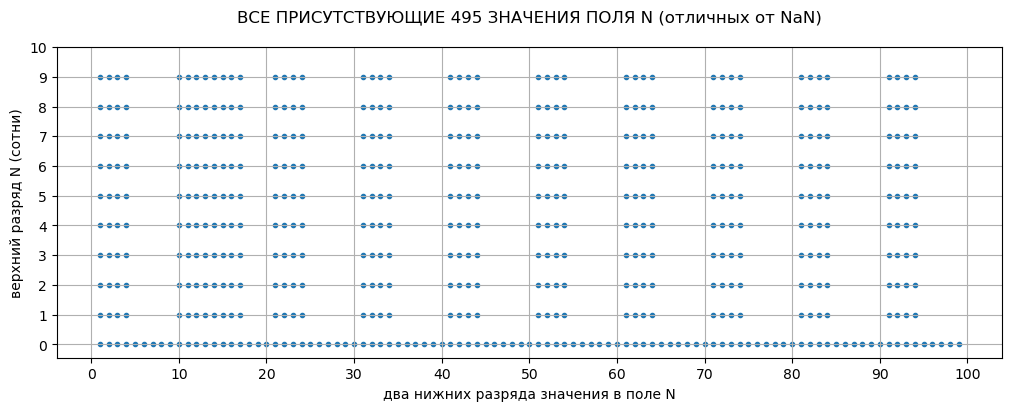

In [22]:
vals = np.sort(id_eda.dropna().N.map(int).unique())
period = 100

plt.figure(figsize=(10,4), layout='constrained')
plt.scatter(vals%(period),vals//(period), marker='.' )

plt.xticks([10*i for i in range(11)])
plt.yticks(range(11))
plt.title('ВСЕ ПРИСУТСТВУЮЩИЕ 495 ЗНАЧЕНИЯ ПОЛЯ N (отличных от NaN)\n')
plt.xlabel('два нижних разряда значения в поле N')
plt.ylabel('верхний разряд N (сотни)')
plt.grid(which='both')
plt.show()

**периодичность интригующая, но идей нет.  Однако, как мы видим, и номера 500 файлов  не случайны, поэтому 5 файлов без номера начинают вызывать подозрения: возможно, это попытка добавить шумы в данные на уровне 1 процента.**

## выводы из EDA индексов записей исходного датасета (ID сегмента ЭЭГ)

1) записи с индексами, где отсутствует третье поле (без префикса), будут отложены как альтернативный тестовый набор для подтверждения гипотезы об их низком качестве (115 записей исходного датасета);
2) остальные записи послужат источником для генерации обучающего и основного тестового набора данных;
3) при разделении обучающего и тестового набора нельзя делить случайно сами записи, но следует делить файлы с сохранением стратификации по классам;
4) возможный смысл разделения на сегменты - в 23*23 = 529 раз улучшается соотношение между количествами записей и признаков - что уменьшит риски переобучения и повысит точность: было 500 записей с 4094 признаками, а стало 11500 записей с 178 признаками!!
5) поэтому собирать сегменты мы не будем, но в конце проверим, насколько в предсказаниях сохранился принцип одного класса для все 23 сегментов одного файла.

# Предобработка данных

## добавляем колонки с id файла целого ЭЭГ и порядковым номером сегмента в нем

In [23]:
raw_df = raw_df.join(id_eda[['N','X']])
raw_df = raw_df.rename(columns={'N':'file_id','X':'segm_no'})
raw_df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X172,X173,X174,X175,X176,X177,X178,y,file_id,segm_no
Unnamed,,,,,,,,,,,,,,,,,,,,,
X21.V1.791,135,190,229,223,192,125,55,-9,-33,-38,...,-31,-77,-103,-127,-116,-83,-51,4,791,21
X15.V1.924,386,382,356,331,320,315,307,272,244,232,...,146,152,157,156,154,143,129,1,924,15
X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,48,19,-12,-30,-35,-35,-36,5,1,8


In [24]:
raw_df.iloc[:,-3:].info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   y        11500 non-null  int64 
 1   file_id  11385 non-null  object
 2   segm_no  11500 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 617.4+ KB


## приводим все вектора сегментов ЭЭГ к одному масштабу
**NB!:** после этого сегменты уже нельзя будет сшить в одну ЭЭГ на 23.6 секунд, но мы и не планируем  

In [25]:
# центрируем
norm_np = (raw_df.iloc[:,:-3].values - raw_df.iloc[:,:-3].mean(axis=1).values.reshape(raw_df.shape[0],1))
# масштабируем
norm_np = (norm_np / raw_df.iloc[:,:-3].std(axis=1, ddof=0).values.reshape(raw_df.shape[0],1))
# восстанавливаем индексы и имена колонок
norm_df = pd.DataFrame(
    index=raw_df.index,
    columns=['X'+str(i) for i in range(1,179)],
    data=norm_np
).copy('deep')
# проверяем
pd.DataFrame(
    index=['new_mean','new_std'],
    data=[norm_df.mean(axis=1).describe(), norm_df.std(axis=1, ddof=0).describe()]
).T

,new_mean,new_std
count,1.150000e+04,1.150000e+04
mean,-6.850521e-21,1.000000e+00
std,9.362638e-17,3.004733e-16
min,-1.185693e-15,1.000000e+00
25%,-4.366046e-17,1.000000e+00
50%,0.000000e+00,1.000000e+00
75%,4.366046e-17,1.000000e+00
max,1.373433e-15,1.000000e+00


**колонки с сигналом ЭЭГ отнормированы - довшиваем обратно разметку и id файла с номером сегмента в нем**

In [26]:
norm_df = norm_df.join(raw_df.iloc[:,-3:])
norm_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X21.V1.791 to X16.V1.210
Columns: 181 entries, X1 to segm_no
dtypes: float64(178), int64(2), object(1)
memory usage: 16.2+ MB


## конвертируем разметку в бинарную
тут некоторая сложность - нам нельзя потерять информацию о стратах, которые представляют собой оригинальную разметку - для будущих разделений датасета на обучающую и тестовую выборки - поэтому действуем чуть сложнее:

In [27]:
norm_df['Y'] = norm_df['y'].map(lambda n: n==1).map(int)
norm_df = norm_df.rename(columns={'y':'group_no'})
norm_df.Y.value_counts(normalize=True)

Y
0    0.8
1    0.2
Name: proportion, dtype: float64

## перемешаем порядок записей в датасете
**NB!:** далее будет нельзя использовать индексы raw_df при восстановлении соотверствия матриц объектам - можно будет пользоваться только датасетом norm_df

In [28]:
norm_df = norm_df.sample(frac=1, axis=0).sample(frac=1, axis=0).sample(frac=1, axis=0).copy('deep')
(norm_df.index == raw_df.index).mean()

np.float64(0.00017391304347826088)

# Извлечение признаков
Какие методы будут релевантны нашим данным - есть мнение, что к нашему случаю лучше всего подойдут частотные и статистические признаки (FFT, NIXTLA.features), и напрасно расходующими свои усилия будут те, что ориентируются на временную динамику и сегментацию (вейвлеты, корреляторы, DTW, псевдо-лингвистические) - вот список причин:
1) у нас нет полного ряда ЭЭГ порядка часа - у нас есть секундные сегменты, на протяжение которых физическое состояние пациента постоянно;
2) у нас нет синхронизации начал сегментов с точки зрения временного паттерна;
3) у нас нет информации о калибровке приборов, следовательно и о масштабе физвеличин согналов (поэтому мы их намеренно отнормировали);
4) из интернета мы знаем, что в ЭЭГ-диагностике ориентируются на присутствие определенного набора "здоровых" частот и пикового характера сигнала при припадке эпилепсии 
5) наши исходные файлы данных ЭЭГ (по 23.6 сек) уже являются результатом отбора характерных сегментов для 5 основных состояний пациента, представляющих интерес, то есть методы сегментации рядов нам не нужны - она уже сделана как надо по семантике данных в их индустрии использования

## спектральные признаки
однако, собственно фурье-преобразование содержит фазы (комплексные коэффициенты разложения), которые при обратном преобразовании воссоздают временную динамику, которую мы договорились не сравнивать - нам нужны лишь амплитуды, или их квадраты, что нам дает спектральную плотность, поэтому по факту мы извлекаем именно ее

### проводим спектральное разложение и собираем датасет спектральной мощности по частотам

In [29]:
norm_df.iloc[:,:-4].shape

(11500, 178)

In [30]:
psd_mtrx = periodogram(norm_df.iloc[:,:-4].values, axis=1)
psd_mtrx[1].shape

(11500, 90)

In [31]:
psd_df = pd.DataFrame(
    index=norm_df.index,
    data=np.log(psd_mtrx[1][:,1:-1])/np.log(10)*10    # мощность будем брать в децибелах (убраны нулевые по амплитуде гармоники)
).copy('deep')

psd_df = psd_df.join(norm_df.iloc[:,-4:]).copy('deep')

### нарисуем разными цветами исходные 5 групп ЭЭГ (исходная разметка)

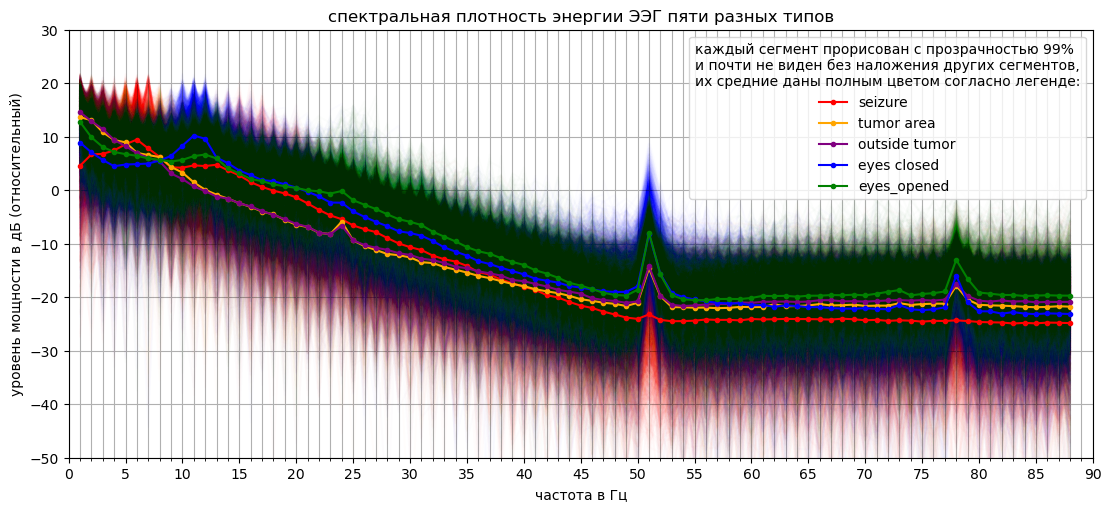

In [32]:
colors = ['red','orange','purple','blue','green']
labels = ['seizure','tumor area', 'outside tumor','eyes closed', 'eyes_opened']

plt.figure(figsize=(11,5), layout='constrained')

for i in range(5):
    case_df = psd_df.query('group_no == (@i+1)')
    for j in range(case_df.shape[0]): 
        plt.plot(range(1,psd_df.shape[1]-3), case_df.iloc[j,:-4], color = colors[i], alpha = 0.01)
for i in range(5):
    case_df = psd_df.query('group_no == (@i+1)')
    plt.plot(range(1,psd_df.shape[1]-3), case_df.iloc[:,:-4].mean(axis=0), color = colors[i], label=labels[i], marker='.')

plt.ylim(-50,30)
plt.xlim(0,90)

plt.xticks([5*i for i in range(19)])
plt.xticks(range(91), minor=True)
plt.grid(which='both')

plt.title('спектральная плотность энергии ЭЭГ пяти разных типов')
plt.xlabel('частота в Гц')
plt.ylabel('уровень мощности в дБ (относительный)')
plt.legend(title='каждый сегмент прорисован с прозрачностью 99%\n'+
                 'и почти не виден без наложения других сегментов,\n'+
                 'их средние даны полным цветом согласно легенде:', loc='upper right')
plt.show()

**такое ощущение, что графики размазаны по вертикали, но имеют более близкую форму - видимо, это эффект нормализации ЭЭГ (на логарифмической шкале это дало хаотический сдвиг по вертикали).  Попробуем центрировать все по вертикали к общему среднему (по факту, мы восстанавливаем неизвестную нам калибровку приборов ЭЭГ):**

In [33]:
# центрируем
psd_df.iloc[:,:-4] = (psd_df.iloc[:,:-4].values - psd_df.iloc[:,:-4].mean(axis=1).values.reshape(raw_df.shape[0],1))

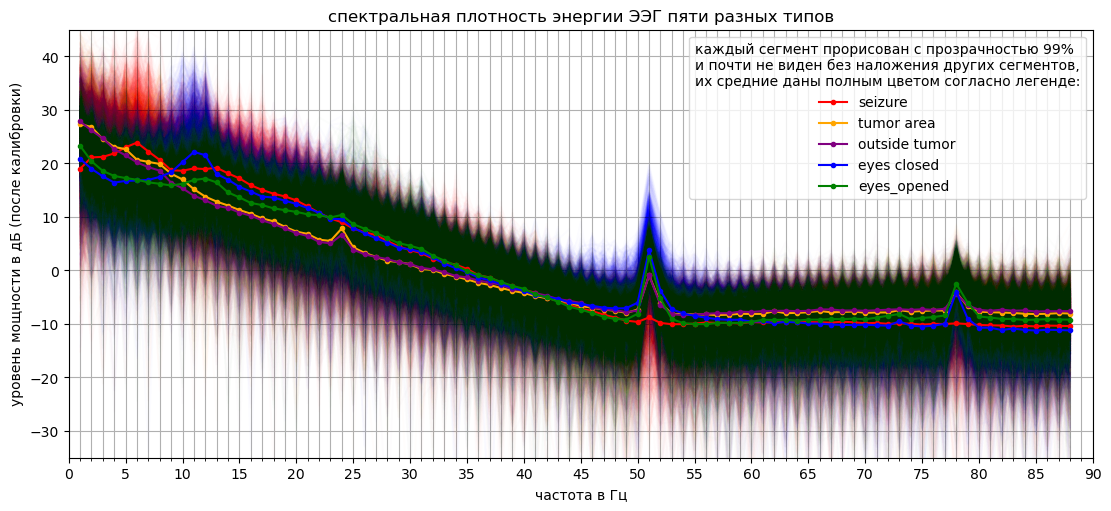

In [34]:
# снова отрисовываем тот же график
plt.figure(figsize=(11,5), layout='constrained')

for i in range(5):
    case_df = psd_df.query('group_no == (@i+1)')
    for j in range(case_df.shape[0]): 
        plt.plot(range(1,psd_df.shape[1]-3), case_df.iloc[j,:-4], color = colors[i], alpha = 0.01)
for i in range(5):
    case_df = psd_df.query('group_no == (@i+1)')
    plt.plot(range(1,psd_df.shape[1]-3), case_df.iloc[:,:-4].mean(axis=0), color = colors[i], label=labels[i], marker='.')

plt.ylim(-35,45)
plt.xlim(0,90)

plt.xticks([5*i for i in range(19)])
plt.xticks(range(91), minor=True)
plt.grid(which='both')

plt.title('спектральная плотность энергии ЭЭГ пяти разных типов')
plt.xlabel('частота в Гц')
plt.ylabel('уровень мощности в дБ (после калибровки)')
plt.legend(title='каждый сегмент прорисован с прозрачностью 99%\n'+
                 'и почти не виден без наложения других сегментов,\n'+
                 'их средние даны полным цветом согласно легенде:', loc='upper right')
plt.show()

**картина поджалась по вертикальным разбросам раза в полтора и еще отчетливее стали видны характерные пики, отсутствием которых целевой класс отличается от остальных**

### SVD разложение и трансформация к главным координатам
по графику спектральной плотности для разных групп мы видим, что признаки на разных частотах имеют разную степень информативности, в такой ситуации полезна SVD (PCA будет нормировать каждую частоту, а нам это не нужно - нам нужно оставить и пики тоже!)

In [35]:
svd_obj = TruncatedSVD(88)
X_svd = svd_obj.fit_transform(psd_df.iloc[:,:-4].values)

**проверим важность компонент**

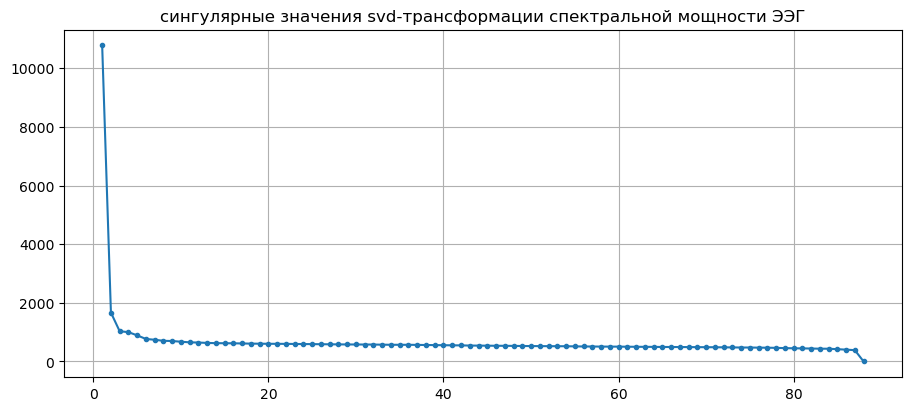

In [36]:
plt.figure(figsize=(9,4), layout='constrained')

plt.plot(range(1,1+len(svd_obj.singular_values_)), svd_obj.singular_values_, marker='.')

plt.title('сингулярные значения svd-трансформации спектральной мощности ЭЭГ')
plt.grid()
plt.show()

**в разделении сегментов наибольший вклад вносят первые две координаты, но, пожалуй, мы оставим все координаты, кроме последней (хоть они и в 100 раз меньше, но их в 100 раз больше):**

In [37]:
svd_psd_df = pd.DataFrame(
    index=norm_df.index,
    data=X_svd[:,:-1]
).copy('deep')

svd_psd_df = svd_psd_df.join(norm_df.iloc[:,-4:]).copy('deep')

**"полюбуемся" на разделение изначальной разметки в координатах главных сомпонент SVD-PSD-трансформации**

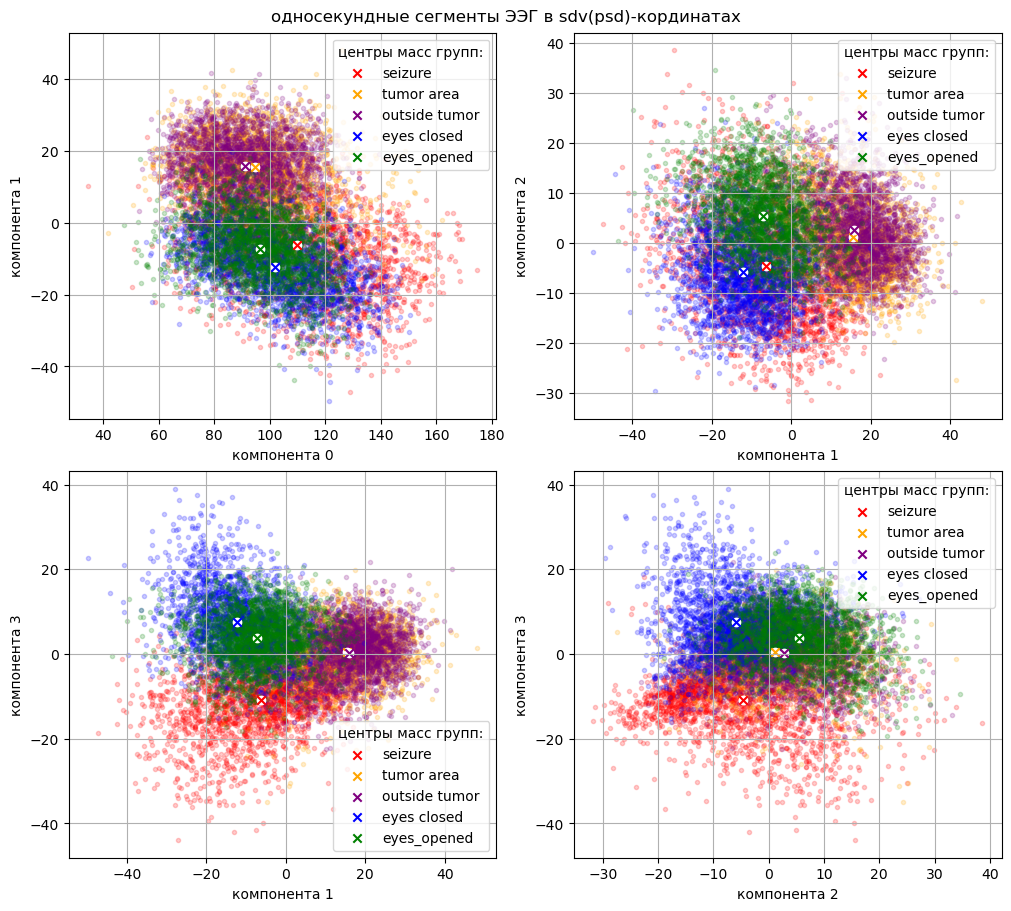

In [38]:
fig, ax = plt.subplots(2,2, figsize=(10,9), layout='constrained')
comps = np.array([
    [(0,1),(1,2)],
    [(1,3),(2,3)]
])

for xc in (0,1):
    for yc in (0,1):
        for i in range(5):
            case_df = svd_psd_df.query('group_no == (@i+1)')
            ax[xc,yc].scatter(case_df.iloc[:,comps[xc,yc][0]], case_df.iloc[:,comps[xc,yc][1]], color = colors[i], marker='.', alpha=0.2)
        ax[xc,yc].grid()
        ax[xc,yc].set_xlabel('компонента '+str(comps[xc,yc][0]))
        ax[xc,yc].set_ylabel('компонента '+str(comps[xc,yc][1]))

for xc in (0,1):
    for yc in (0,1):
        for i in range(5):
            case_df = svd_psd_df.query('group_no == (@i+1)')
            ax[xc,yc].scatter(case_df.iloc[:,comps[xc,yc][0]].mean(), case_df.iloc[:,comps[xc,yc][1]].mean(), 
                              color = 'white', marker='o')
            ax[xc,yc].scatter(case_df.iloc[:,comps[xc,yc][0]].mean(), case_df.iloc[:,comps[xc,yc][1]].mean(), 
                              color = colors[i], label=labels[i], marker='x')
        ax[xc,yc].legend(title='центры масс групп:')

fig.suptitle('односекундные сегменты ЭЭГ в sdv(psd)-кординатах')
plt.show()

### выводы по SVD-компонентам:
1) нулевая компонента просто выделяет направление максимального разброса данных, но слабо разделяет семантические группы;
2) первая компонента хорошо выделяет случаи с опухолью
3) вторая компонента отличает сон от яви, интересно, что припадок похож на сон, согласно ей
4) и наконец, третья компонента хорошо выделяет случаи эпилептических припадков
5) здоровые и больные части при опухоли слабо различаются (как и на исходных спектрограммах мощности)
6) однако в целом перекрытие групп велико, так что может оказаться, что какой-нибудь лес деревьев справится лучше с исходными частотными признаками, чем с svd-координатами этих частотных признаков - увидим!  

### скалирование SVD-признаков
как мы убедились порядок значимости sdv-компонент не следует приоритету нашего целевого класса, поэтому уровняем их значимость перед классификацией

In [39]:
scaler_freq = StandardScaler()
svd_psd_df.iloc[:,:-4] = scaler_freq.fit_transform(svd_psd_df.iloc[:,:-4].values)
svd_psd_df.iloc[:,:-4].std(axis=0,ddof=0).value_counts()

1.0    7
1.0    6
1.0    5
1.0    5
1.0    5
1.0    4
1.0    4
1.0    4
1.0    3
1.0    3
1.0    3
1.0    3
1.0    2
1.0    2
1.0    2
1.0    2
1.0    2
1.0    2
1.0    2
1.0    2
1.0    2
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
1.0    1
Name: count, dtype: int64

## статистические признаки (NIXTLA features)

### переформатируем датасет в панельный формат NIXTLA

In [40]:
ds_list = [pd.to_datetime('2025-11-18') + timedelta(seconds=1.0/177.0)*i for i in range(0,178)]
id_list = list(norm_df.index)

In [41]:
nixtla_panel = pd.concat(
    [pd.DataFrame(
                  index = ['unique_id','ds','y'],
                  data=[
                        [idx for i in range(178)],
                        ds_list,
                        norm_df.iloc[:,:-4].loc[idx,:].values
                       ]
                 ).T for idx in norm_df.index], 
    axis=0, ignore_index=True).copy('deep')

nixtla_panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047000 entries, 0 to 2046999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   unique_id  object
 1   ds         object
 2   y          object
dtypes: object(3)
memory usage: 46.9+ MB


### будем извлекать все, что можно (не выдает ошибки)

In [42]:
extract_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp
]

nixtla_df = tsfeatures(nixtla_panel, freq=1, features=extract_features)

**пустые или константные поля удаляем**

In [43]:
constant_flds = []
for fld in nixtla_df.columns:
    if nixtla_df[fld].nunique() <= 1:
        constant_flds.append(fld)
constant_flds

['unitroot_pp',
 'hw_alpha',
 'hw_beta',
 'hw_gamma',
 'nperiods',
 'seasonal_period',
 'nonlinearity',
 'arch_acf',
 'garch_acf',
 'arch_r2',
 'garch_r2',
 'entropy']

In [44]:
nixtla_df = nixtla_df.drop(columns=constant_flds).set_index('unique_id').loc[norm_df.index,:].copy('deep')
nixtla_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X3.V1.372 to X20.V1.584
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unitroot_kpss    11500 non-null  float64
 1   stability        11500 non-null  float64
 2   trend            11500 non-null  float64
 3   spike            11500 non-null  float64
 4   linearity        11500 non-null  float64
 5   curvature        11500 non-null  float64
 6   e_acf1           11500 non-null  float64
 7   e_acf10          11500 non-null  float64
 8   x_pacf5          11500 non-null  float64
 9   diff1x_pacf5     11500 non-null  float64
 10  diff2x_pacf5     11500 non-null  float64
 11  lumpiness        11500 non-null  float64
 12  alpha            11500 non-null  float64
 13  beta             11500 non-null  float64
 14  flat_spots       11500 non-null  int64  
 15  crossing_points  11500 non-null  int64  
 16  arch_lm          11500 non-null  float64
 17  x_ac

### получили разношерстную окрошку из 23 признаков - причешем ее PCA с нормализацией и центрированием

In [45]:
scaler_stat = StandardScaler()
scaled_nixtla_df = pd.DataFrame(
    index = nixtla_df.index,
    columns = nixtla_df.columns,
    data = scaler_stat.fit_transform(nixtla_df.values)
)
scaled_nixtla_df.shape

(11500, 23)

**контроль:**

In [46]:
pd.DataFrame(index=['mean','std'],
             data=[scaled_nixtla_df.mean(axis=0).describe(), scaled_nixtla_df.std(axis=0, ddof=0).describe()]).T

,mean,std
count,2.300000e+01,2.300000e+01
mean,-5.512079e-17,1.000000e+00
std,9.989832e-16,1.331468e-14
min,-2.525825e-15,1.000000e+00
25%,-2.664921e-16,1.000000e+00
50%,-2.656812e-17,1.000000e+00
75%,3.714903e-17,1.000000e+00
max,3.737455e-15,1.000000e+00


In [47]:
pca_obj = PCA(23)
X_pca = pca_obj.fit_transform(scaled_nixtla_df.values)

**смотрим на сингулярные значения для контроля реальных степеней свободы в данных**

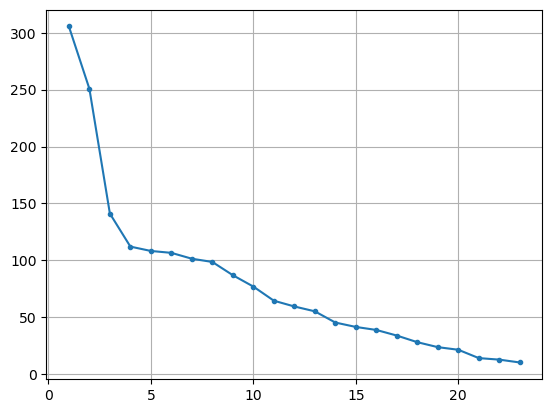

In [48]:
plt.plot(range(1,1+len(pca_obj.singular_values_)), pca_obj.singular_values_, marker='.')

plt.grid()
plt.show()

In [49]:
pca_nixtla_df = pd.DataFrame(
    index=nixtla_df.index,
    data=X_pca
).join(norm_df.iloc[:,-4:])

pca_nixtla_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11500 entries, X3.V1.372 to X20.V1.584
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         11500 non-null  float64
 1   1         11500 non-null  float64
 2   2         11500 non-null  float64
 3   3         11500 non-null  float64
 4   4         11500 non-null  float64
 5   5         11500 non-null  float64
 6   6         11500 non-null  float64
 7   7         11500 non-null  float64
 8   8         11500 non-null  float64
 9   9         11500 non-null  float64
 10  10        11500 non-null  float64
 11  11        11500 non-null  float64
 12  12        11500 non-null  float64
 13  13        11500 non-null  float64
 14  14        11500 non-null  float64
 15  15        11500 non-null  float64
 16  16        11500 non-null  float64
 17  17        11500 non-null  float64
 18  18        11500 non-null  float64
 19  19        11500 non-null  float64
 20  20        11500 non-

# Обучение моделей

In [50]:
cv_no = 10   # здесь задаем количество кросс-валидаций

## классификация на спектральных признаках

### SVD-PSD-координаты

In [51]:
testbis_svd_psd_df = svd_psd_df[svd_psd_df.file_id.isna()]
X_testbis = testbis_svd_psd_df.iloc[:,:-4].values
Y_testbis = testbis_svd_psd_df.iloc[:,:-1].values

In [52]:
test_svd_psd_df = []
train_svd_psd_df = []
nan_svd_psd_df = []
svd_psd_model_hgbc_obj = []

In [53]:
for cv_iter in range(cv_no):
    print('FYI: handling iteration No', cv_iter, '- Please wait!     ', end='\r')

    test_files = []
    for gr in (1,2,3,4,5):
        test_files = test_files + list(np.random.choice(svd_psd_df[svd_psd_df.file_id.notna()].query('group_no == @gr').file_id.unique(), 
                                                        size=20, replace=False))
    test_files = set(test_files)
    
    test_svd_psd_df.append(svd_psd_df[svd_psd_df.file_id.notna()].query('file_id in @test_files').copy('deep'))
    train_svd_psd_df.append(svd_psd_df[svd_psd_df.file_id.notna()].query('file_id not in @test_files').copy('deep'))
    
    X_test = test_svd_psd_df[cv_iter].iloc[:,:-4].values
    Y_test = test_svd_psd_df[cv_iter].iloc[:,-1].values
    X_train = train_svd_psd_df[cv_iter].iloc[:,:-4].values
    Y_train = train_svd_psd_df[cv_iter].iloc[:,-1].values

    svd_psd_model_hgbc_obj.append(HistGradientBoostingClassifier())
    svd_psd_model_hgbc_obj[cv_iter].fit(X_train, Y_train)
    
    test_svd_psd_df[cv_iter]['predict'] = svd_psd_model_hgbc_obj[cv_iter].predict(X_test)
    test_svd_psd_df[cv_iter][['proba_0','proba_1']] = svd_psd_model_hgbc_obj[cv_iter].predict_proba(X_test)
    
    tmp_testbis_svd_psd_df = testbis_svd_psd_df.copy('deep')
    tmp_testbis_svd_psd_df['predict'] = svd_psd_model_hgbc_obj[cv_iter].predict(X_testbis)
    tmp_testbis_svd_psd_df[['proba_0','proba_1']] = svd_psd_model_hgbc_obj[cv_iter].predict_proba(X_testbis)
    nan_svd_psd_df.append(tmp_testbis_svd_psd_df)

print('\nFinished OK !', ' '*50)

FYI: handling iteration No 9 - Please wait!     
Finished OK !                                                   


### PSD-координаты

In [54]:
testbis_psd_df = psd_df[psd_df.file_id.isna()]
X_testbis = testbis_psd_df.iloc[:,:-4].values
Y_testbis = testbis_psd_df.iloc[:,:-1].values

In [55]:
test_psd_df = []
train_psd_df = []
nan_psd_df = []
psd_model_hgbc_obj = []

In [56]:
for cv_iter in range(cv_no):
    print('FYI: handling iteration No', cv_iter, '- Please wait!     ', end='\r')

    test_files = []
    for gr in (1,2,3,4,5):
        test_files = test_files + list(np.random.choice(psd_df[psd_df.file_id.notna()].query('group_no == @gr').file_id.unique(), 
                                                        size=20, replace=False))
    test_files = set(test_files)
    
    test_psd_df.append(psd_df[psd_df.file_id.notna()].query('file_id in @test_files').copy('deep'))
    train_psd_df.append(psd_df[psd_df.file_id.notna()].query('file_id not in @test_files').copy('deep'))
    
    X_test = test_psd_df[cv_iter].iloc[:,:-4].values
    Y_test = test_psd_df[cv_iter].iloc[:,-1].values
    X_train = train_psd_df[cv_iter].iloc[:,:-4].values
    Y_train = train_psd_df[cv_iter].iloc[:,-1].values

    psd_model_hgbc_obj.append(HistGradientBoostingClassifier())
    psd_model_hgbc_obj[cv_iter].fit(X_train, Y_train)
    
    test_psd_df[cv_iter]['predict'] = psd_model_hgbc_obj[cv_iter].predict(X_test)
    test_psd_df[cv_iter][['proba_0','proba_1']] = psd_model_hgbc_obj[cv_iter].predict_proba(X_test)
    
    tmp_testbis_psd_df = testbis_psd_df.copy('deep')
    tmp_testbis_psd_df['predict'] = psd_model_hgbc_obj[cv_iter].predict(X_testbis)
    tmp_testbis_psd_df[['proba_0','proba_1']] = psd_model_hgbc_obj[cv_iter].predict_proba(X_testbis)
    nan_psd_df.append(tmp_testbis_psd_df)

print('\nFinished OK !', ' '*50)

FYI: handling iteration No 9 - Please wait!     
Finished OK !                                                   


## классификация на статистических признаках (NIXTLA features)

In [57]:
testbis_pca_nixtla_df = pca_nixtla_df[pca_nixtla_df.file_id.isna()]
X_testbis = testbis_pca_nixtla_df.iloc[:,:-4].values
Y_testbis = testbis_pca_nixtla_df.iloc[:,:-1].values

In [58]:
test_pca_nixtla_df = []
train_pca_nixtla_df = []
nan_pca_nixtla_df = []
pca_nixtla_model_hgbc_obj = []

In [59]:
for cv_iter in range(cv_no):
    print('FYI: handling iteration No', cv_iter, '- Please wait!     ', end='\r')

    test_files = []
    for gr in (1,2,3,4,5):
        test_files = test_files + list(np.random.choice(pca_nixtla_df[pca_nixtla_df.file_id.notna()].query('group_no == @gr').file_id.unique(), 
                                                        size=20, replace=False))
    test_files = set(test_files)
    
    test_pca_nixtla_df.append(pca_nixtla_df[pca_nixtla_df.file_id.notna()].query('file_id in @test_files').copy('deep'))
    train_pca_nixtla_df.append(pca_nixtla_df[pca_nixtla_df.file_id.notna()].query('file_id not in @test_files').copy('deep'))
    
    X_test = test_pca_nixtla_df[cv_iter].iloc[:,:-4].values
    Y_test = test_pca_nixtla_df[cv_iter].iloc[:,-1].values
    X_train = train_pca_nixtla_df[cv_iter].iloc[:,:-4].values
    Y_train = train_pca_nixtla_df[cv_iter].iloc[:,-1].values

    pca_nixtla_model_hgbc_obj.append(HistGradientBoostingClassifier())
    pca_nixtla_model_hgbc_obj[cv_iter].fit(X_train, Y_train)
    
    test_pca_nixtla_df[cv_iter]['predict'] = pca_nixtla_model_hgbc_obj[cv_iter].predict(X_test)
    test_pca_nixtla_df[cv_iter][['proba_0','proba_1']] = pca_nixtla_model_hgbc_obj[cv_iter].predict_proba(X_test)
    
    tmp_testbis_pca_nixtla_df = testbis_pca_nixtla_df.copy('deep')
    tmp_testbis_pca_nixtla_df['predict'] = pca_nixtla_model_hgbc_obj[cv_iter].predict(X_testbis)
    tmp_testbis_pca_nixtla_df[['proba_0','proba_1']] = pca_nixtla_model_hgbc_obj[cv_iter].predict_proba(X_testbis)
    nan_pca_nixtla_df.append(tmp_testbis_pca_nixtla_df)

print('\nFinished OK !', ' '*50)

FYI: handling iteration No 9 - Please wait!     
Finished OK !                                                   


# Сравнение точности моделей на разных признаках

**итак, резюмируем, что мы напредсказывали выше:**

## таблица точности моделей без вариации порога классов

### спектральные признаки плюс SVD

In [60]:
view_svd_psd = pd.DataFrame(
    index=['accu','prec','rcll','f1'],
    data=[
        [accuracy_score(test_svd_psd_df[i]['Y'].values,  test_svd_psd_df[i]['predict'].values) for i in range(cv_no)],
        [precision_score(test_svd_psd_df[i]['Y'].values, test_svd_psd_df[i]['predict'].values) for i in range(cv_no)],
        [recall_score(test_svd_psd_df[i]['Y'].values,    test_svd_psd_df[i]['predict'].values) for i in range(cv_no)],
        [f1_score(test_svd_psd_df[i]['Y'].values,        test_svd_psd_df[i]['predict'].values) for i in range(cv_no)]
    ]   
)
view_svd_psd['avg'] =  view_svd_psd.iloc[:,:cv_no].mean(axis=1)
view_svd_psd['sigma'] =  view_svd_psd.iloc[:,:cv_no].std(axis=1) / np.sqrt(cv_no)
print('\nТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах SVD(PSD):\n','-'*100)
view_svd_psd


ТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах SVD(PSD):
 ----------------------------------------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,avg,sigma
accu,0.970870,0.983043,0.964348,0.966957,0.958696,0.966957,0.975217,0.965217,0.959130,0.963913,0.967435,0.002330
prec,0.947608,0.966741,0.914474,0.924779,0.939759,0.928571,0.976359,0.967980,0.955224,0.947743,0.946924,0.006415
rcll,0.904348,0.947826,0.906522,0.908696,0.847826,0.904348,0.897826,0.854348,0.834783,0.867391,0.887391,0.011046
f1,0.925473,0.957190,0.910480,0.916667,0.891429,0.916300,0.935447,0.907621,0.890951,0.905789,0.915735,0.006325


### исходные спектральные признаки (PSD)

In [61]:
view_psd = pd.DataFrame(
    index=['accu','prec','rcll','f1'],
    data=[
        [accuracy_score(test_psd_df[i]['Y'].values,  test_psd_df[i]['predict'].values) for i in range(cv_no)],
        [precision_score(test_psd_df[i]['Y'].values, test_psd_df[i]['predict'].values) for i in range(cv_no)],
        [recall_score(test_psd_df[i]['Y'].values,    test_psd_df[i]['predict'].values) for i in range(cv_no)],
        [f1_score(test_psd_df[i]['Y'].values,        test_psd_df[i]['predict'].values) for i in range(cv_no)]
    ]   
)
view_psd['avg'] =  view_psd.iloc[:,:cv_no].mean(axis=1)
view_psd['sigma'] =  view_psd.iloc[:,:cv_no].std(axis=1)/ np.sqrt(cv_no)
print('\nТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах PSD:\n','-'*100)
view_psd


ТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах PSD:
 ----------------------------------------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,avg,sigma
accu,0.984348,0.970000,0.963913,0.981304,0.977826,0.971304,0.980000,0.969565,0.986957,0.952174,0.973739,0.003332
prec,0.951064,0.929670,0.895178,0.948387,0.965831,0.958140,0.966216,0.937220,0.967391,0.920673,0.943977,0.007428
rcll,0.971739,0.919565,0.928261,0.958696,0.921739,0.895652,0.932609,0.908696,0.967391,0.832609,0.923696,0.012855
f1,0.961290,0.924590,0.911419,0.953514,0.943270,0.925843,0.949115,0.922737,0.967391,0.874429,0.933360,0.008750


### статистические признаки NIXTLA плюс PCA

In [62]:
view_pca_nixtla = pd.DataFrame(
    index=['accu','prec','rcll','f1'],
    data=[
        [accuracy_score(test_pca_nixtla_df[i]['Y'].values,  test_pca_nixtla_df[i]['predict'].values) for i in range(cv_no)],
        [precision_score(test_pca_nixtla_df[i]['Y'].values, test_pca_nixtla_df[i]['predict'].values) for i in range(cv_no)],
        [recall_score(test_pca_nixtla_df[i]['Y'].values,    test_pca_nixtla_df[i]['predict'].values) for i in range(cv_no)],
        [f1_score(test_pca_nixtla_df[i]['Y'].values,        test_pca_nixtla_df[i]['predict'].values) for i in range(cv_no)]
    ]   
)
view_pca_nixtla['avg'] =  view_pca_nixtla.iloc[:,:cv_no].mean(axis=1)
view_pca_nixtla['sigma'] =  view_pca_nixtla.iloc[:,:cv_no].std(axis=1)/ np.sqrt(cv_no)
print('\nТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах PCA(NIXTLA):\n','-'*100)
view_pca_nixtla


ТАБЛИЦА ТОЧНОСТИ КРОСС-ВАЛИДАЦИОННЫХ МОДЕЛЕЙ в координатах PCA(NIXTLA):
 ----------------------------------------------------------------------------------------------------


,0,1,2,3,4,5,6,7,8,9,avg,sigma
accu,0.972609,0.964348,0.962174,0.963913,0.957391,0.953043,0.960435,0.961304,0.968261,0.964783,0.962826,0.001720
prec,0.973747,0.941589,0.979434,0.941452,0.909502,0.898190,0.903720,0.942721,0.916129,0.989664,0.939615,0.010400
rcll,0.886957,0.876087,0.828261,0.873913,0.873913,0.863043,0.897826,0.858696,0.926087,0.832609,0.871739,0.009166
f1,0.928328,0.907658,0.897527,0.906426,0.891353,0.880266,0.900763,0.898749,0.921081,0.904368,0.903652,0.004353


### сводная таблица метрик точности для всех моделей на тестовых выборках кросс-валидации 

In [63]:
total_view = view_psd.iloc[:,-2:].join(view_svd_psd.iloc[:,-2:], lsuffix='_psd', rsuffix='_svd_psd').join(
                                       view_pca_nixtla.iloc[:,-2:]).rename(columns={'avg':'avg_pca_nixtla','sigma':'sigma_pca_nixtla'})
print('\nТАБЛИЦА СРЕДНИХ по всем кросс-валидациям МЕТРИК ТОЧНОСТИ НА ТЕСТОВЫХ ВЫБОРКАХ и оценка разброса для среднего значения\n','-'*100)
total_view[sorted(total_view.columns)]


ТАБЛИЦА СРЕДНИХ по всем кросс-валидациям МЕТРИК ТОЧНОСТИ НА ТЕСТОВЫХ ВЫБОРКАХ и оценка разброса для среднего значения
 ----------------------------------------------------------------------------------------------------


,avg_pca_nixtla,avg_psd,avg_svd_psd,sigma_pca_nixtla,sigma_psd,sigma_svd_psd
accu,0.962826,0.973739,0.967435,0.001720,0.003332,0.002330
prec,0.939615,0.943977,0.946924,0.010400,0.007428,0.006415
rcll,0.871739,0.923696,0.887391,0.009166,0.012855,0.011046
f1,0.903652,0.933360,0.915735,0.004353,0.008750,0.006325


## Precision vs Recall & ROC AUC - вариации порога разделения классов

**готовим данные для графиков**

In [64]:
all_svd_psd_df = pd.concat(test_svd_psd_df, axis=0)

PvsR_svd_psd_curve = precision_recall_curve(all_svd_psd_df.Y, all_svd_psd_df.proba_1)
ROC_svd_psd_curve = roc_curve(all_svd_psd_df.Y, all_svd_psd_df.proba_1)
ROC_svd_psd_score = roc_auc_score(all_svd_psd_df.Y, all_svd_psd_df.proba_1)

In [65]:
all_psd_df = pd.concat(test_psd_df, axis=0)

PvsR_psd_curve = precision_recall_curve(all_psd_df.Y, all_psd_df.proba_1)
ROC_psd_curve = roc_curve(all_psd_df.Y, all_psd_df.proba_1)
ROC_psd_score = roc_auc_score(all_psd_df.Y, all_psd_df.proba_1)

In [66]:
all_pca_nixtla_df = pd.concat(test_pca_nixtla_df, axis=0)

PvsR_pca_nixtla_curve = precision_recall_curve(all_pca_nixtla_df.Y, all_pca_nixtla_df.proba_1)
ROC_pca_nixtla_curve = roc_curve(all_pca_nixtla_df.Y, all_pca_nixtla_df.proba_1)
ROC_pca_nixtla_score = roc_auc_score(all_pca_nixtla_df.Y, all_pca_nixtla_df.proba_1)

**смотрим на графиках**

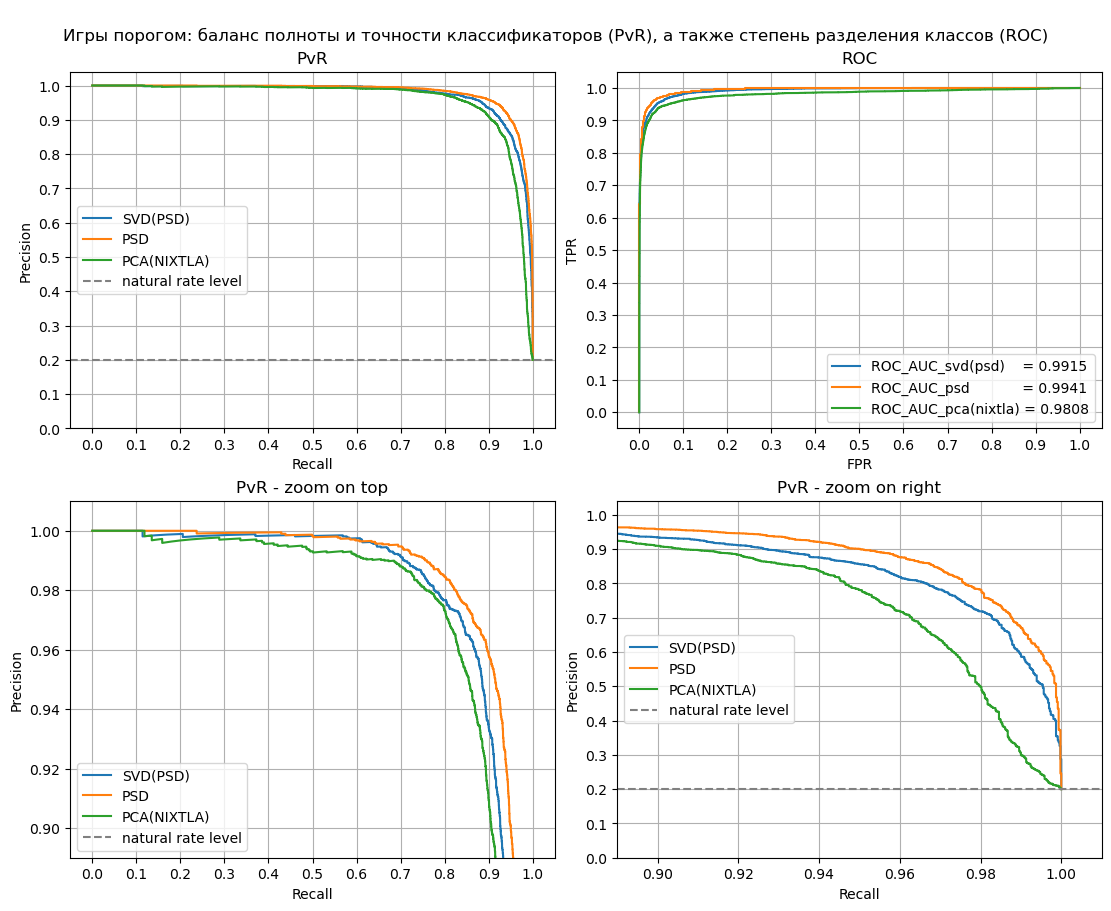

In [67]:
fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(11,9), layout='constrained')

ax1.plot(PvsR_svd_psd_curve[1],PvsR_svd_psd_curve[0],label='SVD(PSD)')
ax1.plot(PvsR_psd_curve[1],PvsR_psd_curve[0],label='PSD')
ax1.plot(PvsR_pca_nixtla_curve[1],PvsR_pca_nixtla_curve[0],label='PCA(NIXTLA)')
ax1.axhline(0.2, color='gray', ls='--', label='natural rate level')
ax1.set_xticks([i/10 for i in range(11)])
ax1.set_yticks([i/10 for i in range(11)])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PvR')
ax1.grid()
ax1.legend()

ax2.plot(ROC_svd_psd_curve[0],ROC_svd_psd_curve[1],label='ROC_AUC_svd(psd)    = '+str(round(ROC_svd_psd_score,4)))
ax2.plot(ROC_psd_curve[0],ROC_psd_curve[1],label='ROC_AUC_psd            = '+str(round(ROC_psd_score,4)))
ax2.plot(ROC_pca_nixtla_curve[0],ROC_pca_nixtla_curve[1],label='ROC_AUC_pca(nixtla) = '+str(round(ROC_pca_nixtla_score,4)))
ax2.set_xticks([i/10 for i in range(11)])
ax2.set_yticks([i/10 for i in range(11)])
ax2.set_xlabel('FPR')
ax2.set_ylabel('TPR')
ax2.set_title('ROC')
ax2.grid()
ax2.legend()

ax3.plot(PvsR_svd_psd_curve[1],PvsR_svd_psd_curve[0],label='SVD(PSD)')
ax3.plot(PvsR_psd_curve[1],PvsR_psd_curve[0],label='PSD')
ax3.plot(PvsR_pca_nixtla_curve[1],PvsR_pca_nixtla_curve[0],label='PCA(NIXTLA)')
ax3.axhline(0.2, color='gray', ls='--', label='natural rate level')
ax3.set_xticks([i/10 for i in range(11)])
ax3.set_ylim(0.89,1.01)
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_title('PvR - zoom on top')
ax3.grid()
ax3.legend()

ax4.plot(PvsR_svd_psd_curve[1],PvsR_svd_psd_curve[0],label='SVD(PSD)')
ax4.plot(PvsR_psd_curve[1],PvsR_psd_curve[0],label='PSD')
ax4.plot(PvsR_pca_nixtla_curve[1],PvsR_pca_nixtla_curve[0],label='PCA(NIXTLA)')
ax4.axhline(0.2, color='gray', ls='--', label='natural rate level')
ax4.set_xlim(0.89,1.01)
ax4.set_yticks([i/10 for i in range(11)])
ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('PvR - zoom on right')
ax4.grid()
ax4.legend()

fig.suptitle('\nИгры порогом: баланс полноты и точности классификаторов (PvR), а также степень разделения классов (ROC)')
plt.show()

# Метод суда присяжных на дополнительной тестовой выборке (*NaN-files*)

**напомним, что у нас изначально ровно 1% данных не имел идентификатора файла, хотя стратификация по 5 группам в нем сохранялась: 115 записей по 23 их каждой группы.  Мы заподозрили возможный вброс шума и сразу отложили их из кросс-валидации - как дополнительную тестовую выборку.  Проверим точность предсказания на них теперь.  Поскольку, в отличие от тестовой выборки кросс-валидации, их состав постоянен, мы можем усилить нашу модель для них, объединив предсказания кросс-валидационных моделей в решение присяжных**

## докинем суффиксы к названиям колонок, чтобы можно было конкатенировать

In [68]:
for i, df in enumerate(nan_svd_psd_df):
    df.columns = [str(fld)+'_cv'+str(i) for fld in df.columns]

In [69]:
for i, df in enumerate(nan_psd_df):
    df.columns = [str(fld)+'_cv'+str(i) for fld in df.columns]

In [70]:
for i, df in enumerate(nan_pca_nixtla_df):
    df.columns = [str(fld)+'_cv'+str(i) for fld in df.columns]

## соберем все решения присяжных и посмотрим сводную статистику

In [71]:
jury_svd_psd = pd.concat([df.iloc[:,-3] for df in nan_svd_psd_df], axis=1)
jury_svd_psd.mean(axis=1).value_counts()

0.0    92
1.0    22
0.8     1
Name: count, dtype: int64

**как видим выше, мнение присяжных разошлось только в одном случае - одна-две из кросс-валидационных моделей пропускают один сегмент с эпилептическим припадком в FN**

In [72]:
jury_psd = pd.concat([df.iloc[:,-3] for df in nan_psd_df], axis=1)
jury_psd.mean(axis=1).value_counts()

0.0    91
1.0    23
0.5     1
Name: count, dtype: int64

**а вот тут присяжные разделились ровно попалам в отношении одного из неприпадочных сегментов**

In [73]:
jury_pca_nixtla = pd.concat([df.iloc[:,-3] for df in nan_pca_nixtla_df], axis=1)
jury_pca_nixtla.mean(axis=1).value_counts()

0.0    92
1.0    23
Name: count, dtype: int64

**а в статистических признаках присяжные было единодушны во всех 115 случаях!**

**мы не стали проводить расчеты метрик, так как статистика выше показывает абсолютную точность в решении присяжных, а размер выборки всего 115 и дискретность не позволяет нам посчитать метрики или построить графики сс большей точностью. Единственный и последний момент здесь: убедимся, не были ли перепутаны группы целиком с целевой - сделаем это на nixtla, так как там присяжные были единогласны, и мы просто сравним разметку с голосом нулевого присяжного:**

In [74]:
print('FYI: перепутано', (nan_pca_nixtla_df[0].Y_cv0 != nan_pca_nixtla_df[0].predict_cv0).sum(), 'записей!')

FYI: перепутано 0 записей!


# ВЫВОДЫ:
1) в целом и спектральные и статистические признаки позволили разделить классы методом XGBoost на уровне ROC-AUC 98-99%;
2) статистические признаки потеряли 1-2% целевого класса - просто не видят их;
3) статистические признаки производят менее чистый дистиллят возле порогов proba 0+ и 1-;
4) подозрения в отношении 
5) дополнительная SVD-трансформация спектральных признаков приводит к потере возле оптимального f1, но улучшает показатели при фокусе на точность по целевому классу: выход на чистый дистиллят (Precision = 1) происходит при следующих уровнях охвата (Recall), соответственно:
*  SVD(PSD) - Recall = 30-40% (эти цифры меняются при повторных прогонах, так как мы не зафиксировали random_state)
*  PSD - Recall = 10-15%
*  PCA(NIXTLA) - Recall = 3-10%

# <<<<< THE END >>>>>

In [75]:
myrun_stop = datetime.now()
print('LAST RUN ON', str(myrun_start).split('.')[0])
print('total run time was', round((myrun_stop - myrun_start).total_seconds(),1), 'seconds')

LAST RUN ON 2025-11-18 23:52:41
total run time was 155.0 seconds
